## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

## 結果
將regulizer換成L1_L2 ,並在以下條件下找到最佳準確度0.86:

epoch=50<br>
Learining Rate = 0.01<br>
L1 ratio = 1e-6<br>
L2 ratio = 0<br>

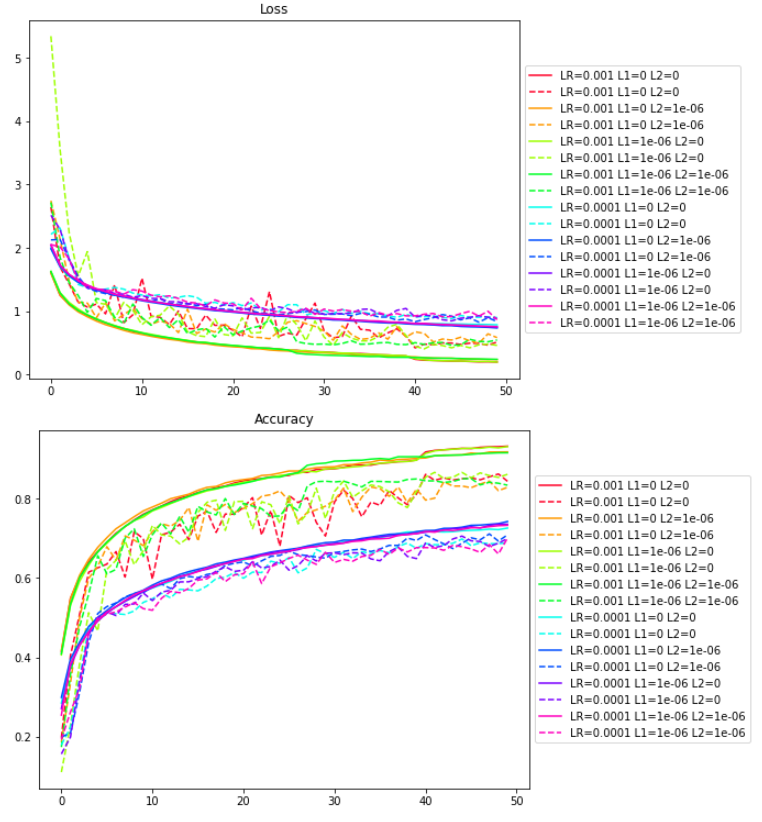


## 這裡是範例模型 (作業在下個section)

In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet(input_shape, depth=29, num_classes=10):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [2]:
from keras.datasets import cifar10
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical


In [3]:
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
# 建立 ResNet 模型
model = resnet(input_shape=(32,32,3)) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
batch_size = 64 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 30 # 訓練整個資料集共 30個循環


model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
782/782 [==============================] - 65s 38ms/step - loss: 2.0822 - accuracy: 0.4330 - val_loss: 1.5592 - val_accuracy: 0.5813
Epoch 2/30
782/782 [==============================] - 29s 37ms/step - loss: 1.3770 - accuracy: 0.6462 - val_loss: 1.6778 - val_accuracy: 0.5485
Epoch 3/30
782/782 [==============================] - 29s 37ms/step - loss: 1.1395 - accuracy: 0.7148 - val_loss: 1.4733 - val_accuracy: 0.6002
Epoch 4/30
782/782 [==============================] - 29s 37ms/step - loss: 0.9925 - accuracy: 0.7590 - val_loss: 1.1726 - val_accuracy: 0.7104
Epoch 5/30
782/782 [==============================] - 29s 37ms/step - loss: 0.8844 - accuracy: 0.7913 - val_loss: 1.2132 - val_accuracy: 0.7074
Epoch 6/30
782/782 [==============================] - 29s 37ms/step - loss: 0.8083 - accuracy: 0.8204 - val_loss: 1.1817 - val_accuracy: 0.7067
Epoch 7/30
782/782 [==============================] - 29s 37ms/step - loss: 0.7397 - accuracy: 0.8443 - val_loss: 1.2454 - val_accuracy:

## 作業 (調整模型找出最佳參數)

In [6]:
import itertools
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l1_l2
from keras.preprocessing.image import ImageDataGenerator

In [7]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True,
                 l1_ratio=0,
                 l2_ratio=0):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet(input_shape, depth=29, num_classes=10, l1_ratio=0, l2_ratio=0):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True,
                     l1_ratio=0, 
                     l2_ratio=0)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
batch_size = 512 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 50 # 訓練整個資料集共 30個循環

LR = [1e-3, 1e-4]
L1_EXP = [0, 1e-6]
L2_EXP = [0, 1e-6]


In [9]:
results = {}
for k, l, m in itertools.product(LR, L1_EXP, L2_EXP):
  keras.backend.clear_session()
  print(f'EXP: LR={k} L1={l} L2={m}')
  augment_generator = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  model = resnet(input_shape=(32,32,3), l1_ratio=l, l2_ratio=m) 
  # model.summary()
  
  reduce_lr = ReduceLROnPlateau(factor=0.3, 
                    min_lr=1e-9, 
                    monitor='val_accuracy', 
                    patience=8, 
                    verbose=1)
  model.compile(loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=k),
        metrics=['accuracy'])

  model.fit_generator(augment_generator.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=int(len(x_train)/batch_size),
        epochs=epochs,
        verbose=1,
        validation_data=(x_test, y_test),
        shuffle=True,
        callbacks=[reduce_lr])
        
  train_loss = model.history.history["loss"]
  valid_loss = model.history.history["val_loss"]
  train_acc = model.history.history["accuracy"]
  valid_acc = model.history.history["val_accuracy"]

  name_tag = f'LR={k} L1={l} L2={m}'
  results[name_tag] = {
      'train_loss': train_loss,
      'valid_loss': valid_loss,
      'train_acc': train_acc,
      'valid_acc': valid_acc}


EXP: LR=0.001 L1=0 L2=0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
97/97 [==============================] - 35s 319ms/step - loss: 1.8261 - accuracy: 0.3320 - val_loss: 2.6428 - val_accuracy: 0.1977
Epoch 2/50
97/97 [==============================] - 30s 305ms/step - loss: 1.2987 - accuracy: 0.5297 - val_loss: 1.6974 - val_accuracy: 0.4047
Epoch 3/50
97/97 [==============================] - 30s 306ms/step - loss: 1.1382 - accuracy: 0.5901 - val_loss: 1.4293 - val_accuracy: 0.5083
Epoch 4/50
97/97 [==============================] - 30s 306ms/step - loss: 1.0271 - accuracy: 0.6330 - val_loss: 1.1397 - val_accuracy: 0.6148
Epoch 5/50
97/97 [==============================] - 30s 304ms/step - loss: 0.9410 - accuracy: 0.6647 - val_loss: 1.0639 - val_accuracy: 0.6259
Epoch 6/50
97/97 [==============================] - 30s 306ms/step - loss: 0.8716 - accuracy: 0.6907 - val_loss: 1.1105 - val_accuracy: 0.6352
Epoch 7/50
97/97 [==============================] - 30s 305ms/step - loss: 0.8231 - accuracy: 0.7085 - val_loss: 0.9567 - val_accuracy: 0.6667

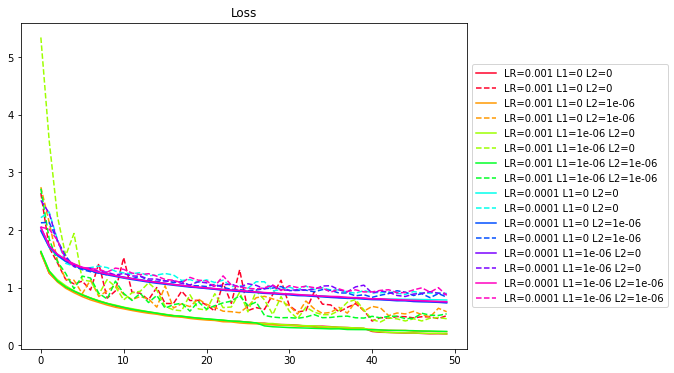

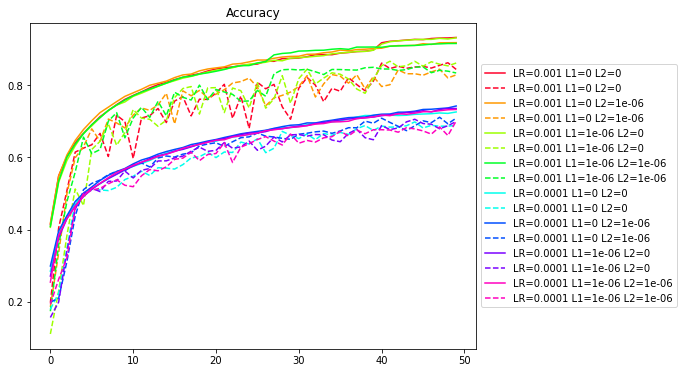

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## 進階挑戰!
有志以成為機器學習工程師為目標的同學們可以參加這個挑戰，這[網站](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)記錄了歷年來 Cifar-10 中排名最高的論文，請試著閱讀論文並撰寫出相對應的程式碼，復現出論文的結果。

這樣的能力在機器學習領域中是非常重要的，具備閱讀他人論文並實現的能力，可為自己在履歷上增添不少分數，當然難度也相當高，若是不透徹了解文章內容或是程式能力不夠紮實，可是不能復現別人辛苦的研究成果的喔! 就請各位同學好好努力，往自己的機器學習之路邁進吧:)